## Evaluation market conditions and estimate systematic risk

> **This module is for understanding Macro Indicators vs. Stock Markets Growth**
* To Understand the correlation of Stock Market Growth and Macro Indicators
* To predict Additional factors to consider when trying to explain or predict the stock movements 
* **Process** Use datasources FRED, Nasdaq Data (former QUANDL), STOOQ accessible through Pandas DataReader (pdr) analyze the macro variable changes on stock price
* **Plan**
  0. Identify sources and installs required libraries
  1. Get Data from the sources
  2. Add Transformations (e.g. Day-to-Day (DoD), WoW, MoM, YoY) 
  3. Combine all series in one dataframe
  4. Correlation analysis


In [1]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install quandl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import quandl

from datetime import date
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import yfinance as yf
from tqdm import tqdm

In [4]:
# Macro economic indicators from the FRED database

FRED_Indicators = ['GDP', 'GDPC1', 'GDPPOT', 'NYGDPMKTPCDWLD', # 1. GDP related data
                   'CPIAUCSL', 'CPILFESL', 'GDPDEF', # 2. Inflation related data
                   'M1SL', 'WM1NS', 'WM2NS', 'M1V', 'M2V', 'WALCL', # 3. Money Supply
                   'DFF', 'DTB3', 'DGS2', 'DGS5', 'DGS10', 'DGS30', 'T5YIE','T10YIE', 'T5YIFR', 'TEDRATE', 'DPRIME', # 4. Interest Rates
                   'UNRATE', 'NROU', 'CIVPART', 'EMRATIO', 'UNEMPLOY', 'PAYEMS', 'MANEMP', 'ICSA', 'IC4WSA', # 5. Employment
                   'CDSP', 'MDSP', 'FODSP', 'DSPIC96', 'PCE', 'PCEDG', 'PSAVERT', 'DSPI', 'RSXFS', # 6. Income and Expenditure
                   'INDPRO', 'TCU', 'HOUST', 'GPDI', 'CP', 'STLFSI2', 'DCOILWTICO', 'DTWEXAFEGS', 'DTWEXBGS', # 7. Other indicators
                   'GFDEBTN', 'GFDEGDQ188S', # 8. Gov-t debt
                   'DEXUSEU', 'GVZCLS', 'VIXCLS', 'DIVIDEND', 'MORTGAGE30US', 'SPCS20RSA'# 9. Additional indicators from IVAN
                   ]

# Macro Indicators from QUANDL
QUANDL_Indicators = {'BCHAIN/MKPRU', 'USTREASURY/YIELD', 'USTREASURY/REALYIELD', 'MULTPL/SHILLER_PE_RATIO_MONTH', 'LBMA/GOLD'  # 10. Additional indicators from IVAN           
                     }

# Stock maret indexes
# All indexes: https://stooq.com/t/ 
STOOQ_Indicators = {'^DJI','^SPX'}  

# update period for each ind (Y=Yearly, Q=Quarterly, M=Monthly, W=Weekly, D=Daily)
indicators_periods = {'GDP': 'Q', 'GDPC1': 'Q', 'GDPPOT': 'Q', 'NYGDPMKTPCDWLD': 'Y',                 # 1. Growth
                      # 2. Prices and Inflation
                      'CPIAUCSL': 'M', 'CPILFESL': 'M', 'GDPDEF': 'Q',
                      # 3. Money Supply
                      'M1SL': 'M', 'WM1NS': 'W', 'WM2NS': 'W', 'M1V': 'Q', 'M2V': 'Q', 'WALCL': 'W',
                      # 4. Interest Rates
                      'DFF': 'D', 'DTB3': 'D', 'DGS2': 'D', 'DGS5': 'D', 'DGS10': 'D', 'DGS30': 'D', 
                      # 4. Interest Rates
                      'T5YIE': 'D', 'T10YIE': 'D', 'T5YIFR': 'D', 'TEDRATE': 'D', 'DPRIME': 'D',
                      # 5. Employment
                      'UNRATE': 'M', 'NROU': 'Q', 'CIVPART': 'M', 'EMRATIO': 'M',
                      # 5. Employment
                      'UNEMPLOY': 'M', 'PAYEMS': 'M', 'MANEMP': 'M', 'ICSA': 'W', 'IC4WSA': 'W',
                      # 6. Income and Expenditure
                      'CDSP': 'Q', 'MDSP': 'Q', 'FODSP': 'Q', 'DSPIC96': 'M', 'PCE': 'M', 'PCEDG': 'M',
                      # 6. Income and Expenditure
                      'PSAVERT': 'M', 'DSPI': 'M', 'RSXFS': 'M',
                      # 7. Other indicators
                      'INDPRO': 'M', 'TCU': 'M', 'HOUST': 'M', 'GPDI': 'Q', 'CP': 'Q', 'STLFSI2': 'W',
                      # 7. Other indicators
                      'DCOILWTICO': 'D', 'DTWEXAFEGS': 'D', 'DTWEXBGS': 'D',
                      # 8. Gov-t debt
                      'GFDEBTN': 'Q', 'GFDEGDQ188S': 'Q',
                      # 9. FRED: Additional indicators from IVAN
                      'DEXUSEU': 'D', 'GVZCLS': 'D', 'VIXCLS': 'D', 'DIVIDEND': 'Q',
                      # 9. FRED: Additional indicators from IVAN
                      'MORTGAGE30US': 'W', 'SPCS20RSA': 'M',
                      # 9.QUANDL: Additional indicators from IVAN
                      'BCHAIN_MKPRU': 'D', 'USTREASURY_YIELD': 'D', 'USTREASURY_REALYIELD': 'D',
                      'MULTPL_SHILLER_PE_RATIO_MONTH': 'M', 'LBMA_GOLD': 'D',
                      # 10. INDEXES
                      'SPX': 'D', 'DJI': 'D'
                      }

In [5]:
end = date.today()
start = date(year=end.year-35, month=end.month, day=end.day)
macro_indicators = dict()
tqdm_fred = tqdm(FRED_Indicators)

# get the stats from FRED database (with Pandas Datareader API)
tqdm_fred.set_description('Downloading stats from FRED:')
for indicator in tqdm_fred:
  # tqdm_fred.set_description(indicator)
  # macro_indicators[indicator] = pdr.DataReader(indicator, "fred", start=start, timeout=90)
  macro_indicators[indicator] = pdr.fred.FredReader(indicator, start=start, timeout=90).read()

In [6]:
tqdm_quandl = tqdm(QUANDL_Indicators)
# get the stats from QUANDL database
tqdm_quandl.set_description("Downloading stats from QUANDL:")
for indicator in tqdm_quandl:
 # tqdm_quandl.set_description(indicator)
 # modify all indicator names '/': like "USTREASURY/YIELD" to "USTREASURY_YIELD"
 macro_indicators[indicator.replace("/", "_")] = quandl.get(indicator, start_date=start, end_date=end, authtoken="5qE7KbLemDiZ9RfNsVuM")

In [7]:
macro_indicators['GDP']

,GDP
DATE,
1988-07-01,5282.835
1988-10-01,5399.509
1989-01-01,5511.253
1989-04-01,5612.463
1989-07-01,5695.365
...,...
2022-01-01,24740.480
2022-04-01,25248.476
2022-07-01,25723.941


In [8]:
for indicator in tqdm(STOOQ_Indicators):
  macro_indicators[indicator.replace("^", "")]= pdr.get_data_stooq(indicator, start, end)

100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


In [9]:
for i,value in enumerate(macro_indicators.keys()):
  if i%6==0:
    print('\n')
  print(value, end =", ")  



GDP, GDPC1, GDPPOT, NYGDPMKTPCDWLD, CPIAUCSL, CPILFESL, 

GDPDEF, M1SL, WM1NS, WM2NS, M1V, M2V, 

WALCL, DFF, DTB3, DGS2, DGS5, DGS10, 

DGS30, T5YIE, T10YIE, T5YIFR, TEDRATE, DPRIME, 

UNRATE, NROU, CIVPART, EMRATIO, UNEMPLOY, PAYEMS, 

MANEMP, ICSA, IC4WSA, CDSP, MDSP, FODSP, 

DSPIC96, PCE, PCEDG, PSAVERT, DSPI, RSXFS, 

INDPRO, TCU, HOUST, GPDI, CP, STLFSI2, 

DCOILWTICO, DTWEXAFEGS, DTWEXBGS, GFDEBTN, GFDEGDQ188S, DEXUSEU, 

GVZCLS, VIXCLS, DIVIDEND, MORTGAGE30US, SPCS20RSA, USTREASURY_YIELD, 

USTREASURY_REALYIELD, LBMA_GOLD, MULTPL_SHILLER_PE_RATIO_MONTH, BCHAIN_MKPRU, DJI, SPX, 

In [10]:
macro_indicators['SPX'].tail()

,Open,High,Low,Close,Volume
Date,,,,,
1988-06-06,266.46,267.05,264.97,267.05,84700000.0
1988-06-03,265.34,267.11,264.42,266.45,105333333.0
1988-06-02,266.65,266.71,264.12,265.33,107522222.0
1988-06-01,262.16,267.43,262.10,266.69,130311111.0
1988-05-31,253.44,262.16,253.42,262.16,137561111.0


In [11]:
macro_indicators['SPX'] = macro_indicators['SPX'].reindex(index=macro_indicators['SPX'].index[::-1])
macro_indicators['DJI'] = macro_indicators['DJI'].reindex(index=macro_indicators['DJI'].index[::-1])

<Axes: title={'center': 'S&P500 Stock index'}, xlabel='Date'>

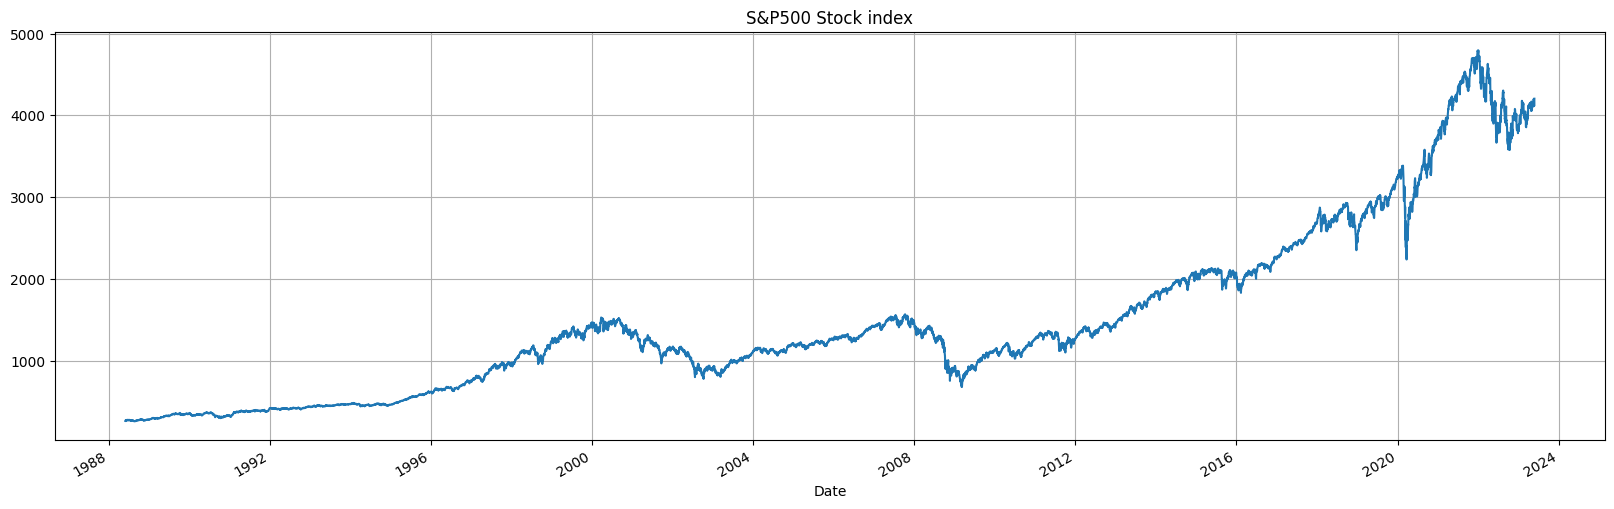

In [12]:
macro_indicators['SPX']['Close'].plot.line(figsize=(20,6), grid = True, title='S&P500 Stock index')

<Axes: title={'center': ' CBOE Volatility Index: VIX (VIXCLS)\t - daily'}, xlabel='DATE'>

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 9 (	) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


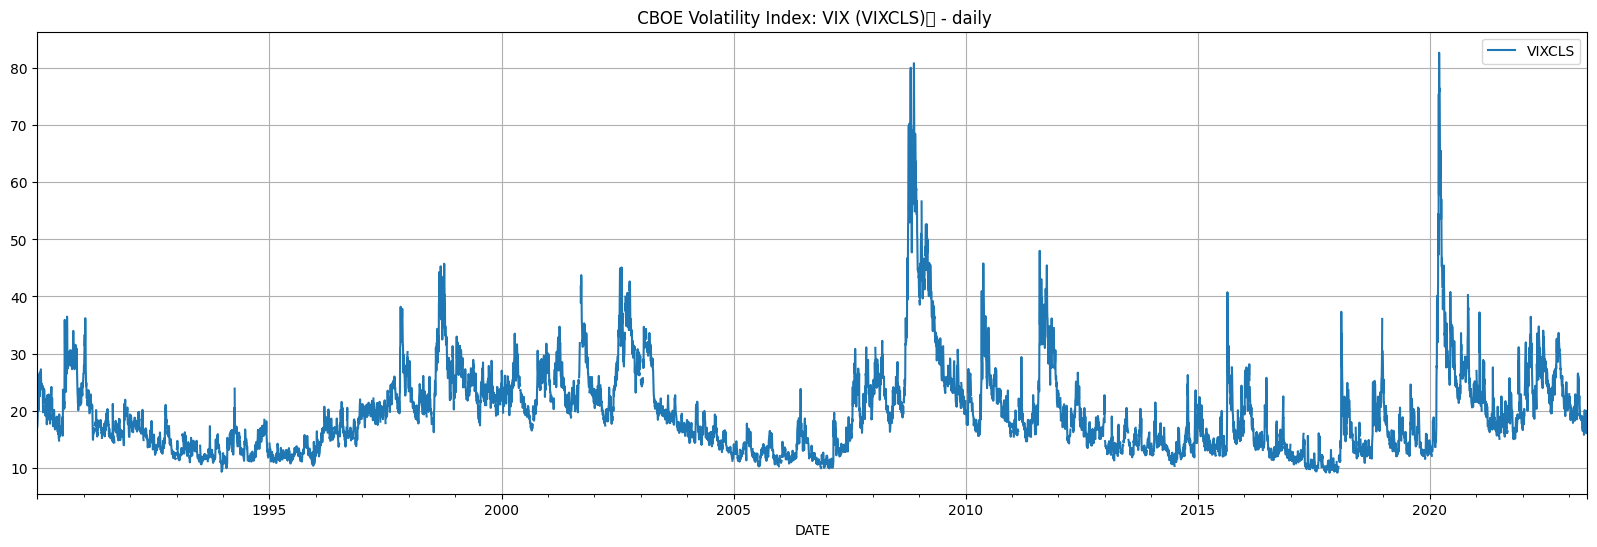

In [13]:
# https://fred.stlouisfed.org/series/VIXCLS
macro_indicators['VIXCLS'].plot.line(figsize=(20,6), grid = True, title=' CBOE Volatility Index: VIX (VIXCLS)	 - daily')

<Axes: title={'center': 'DJI Stock index'}, xlabel='Date'>

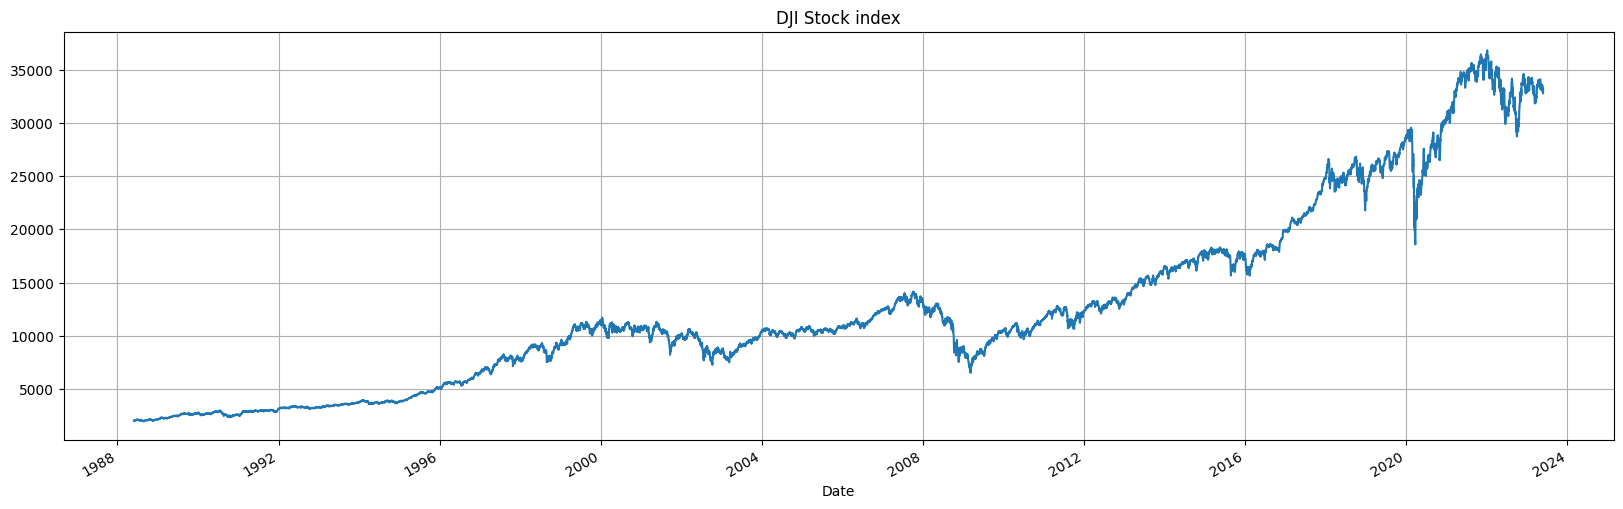

In [14]:
macro_indicators['DJI']['Close'].plot.line(figsize=(20,6), grid = True, title='DJI Stock index')

<Axes: title={'center': 'CBOE Gold ETF Volatility Index (GVZCLS) - daily'}, xlabel='DATE'>

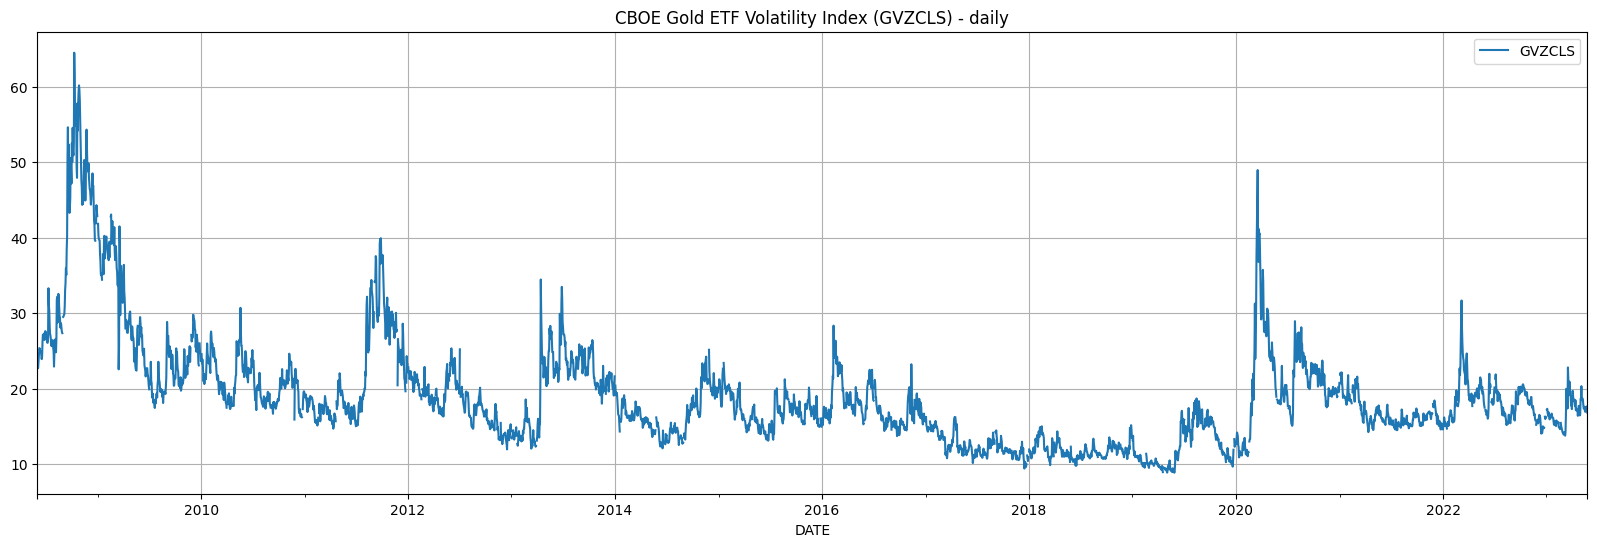

In [15]:
# https://fred.stlouisfed.org/series/GVZCLS
macro_indicators['GVZCLS'].plot.line(figsize=(20,6), grid = True, title='CBOE Gold ETF Volatility Index (GVZCLS) - daily')

<Axes: title={'center': 'St. Louis Fed Financial Stress Index (STLFSI2) - daily'}, xlabel='DATE'>

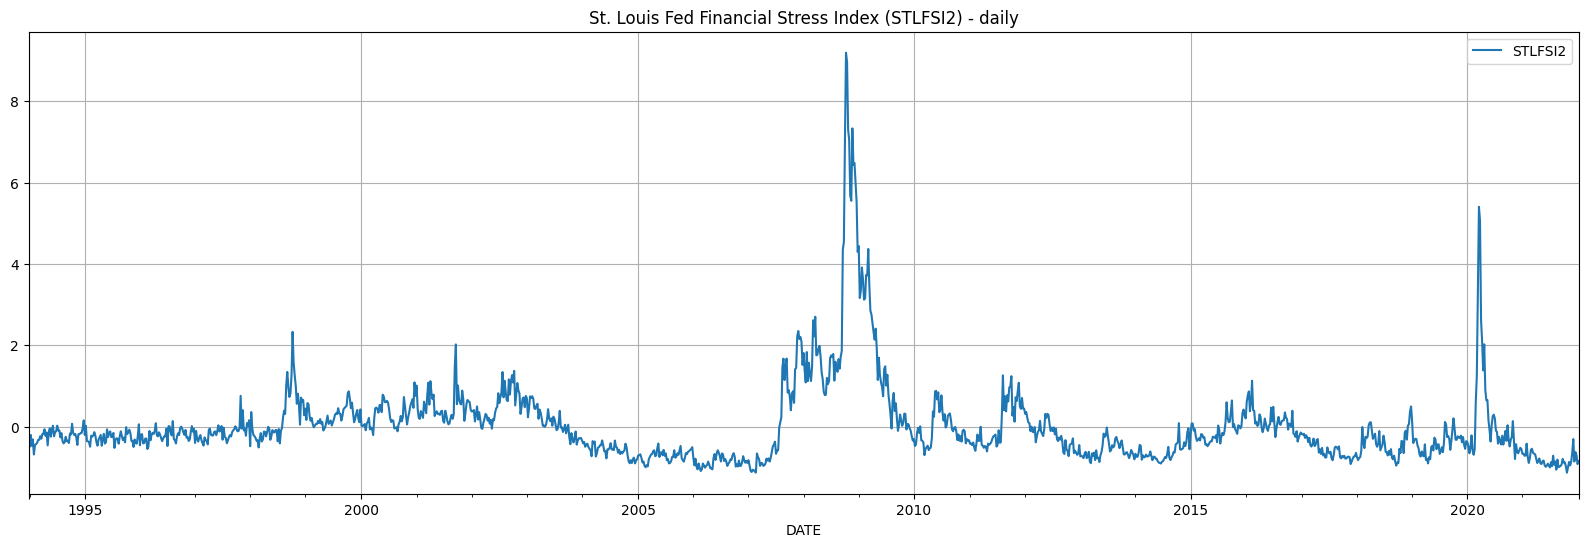

In [16]:
# https://fred.stlouisfed.org/series/STLFSI2
macro_indicators['STLFSI2'].plot.line(figsize=(20,6), grid = True, title='St. Louis Fed Financial Stress Index (STLFSI2) - daily')

<Axes: title={'center': ' Household Financial Obligations as a Percent of Disposable Personal Income (FODSP) - Quarterly'}, xlabel='DATE'>

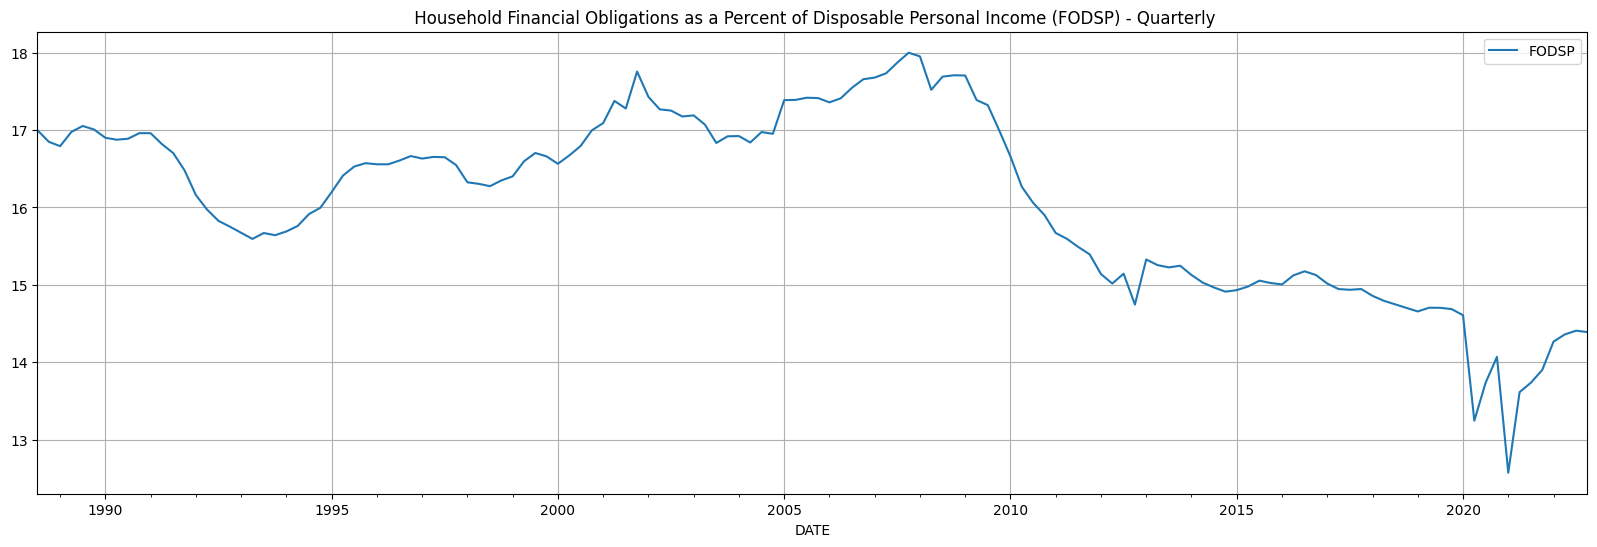

In [17]:
# https://fred.stlouisfed.org/series/FODSP
macro_indicators['FODSP'].plot.line(figsize=(20,6), grid = True, title=' Household Financial Obligations as a Percent of Disposable Personal Income (FODSP) - Quarterly')

<Axes: title={'center': 'Shiller PE Ratio - Monthly'}, xlabel='Date'>

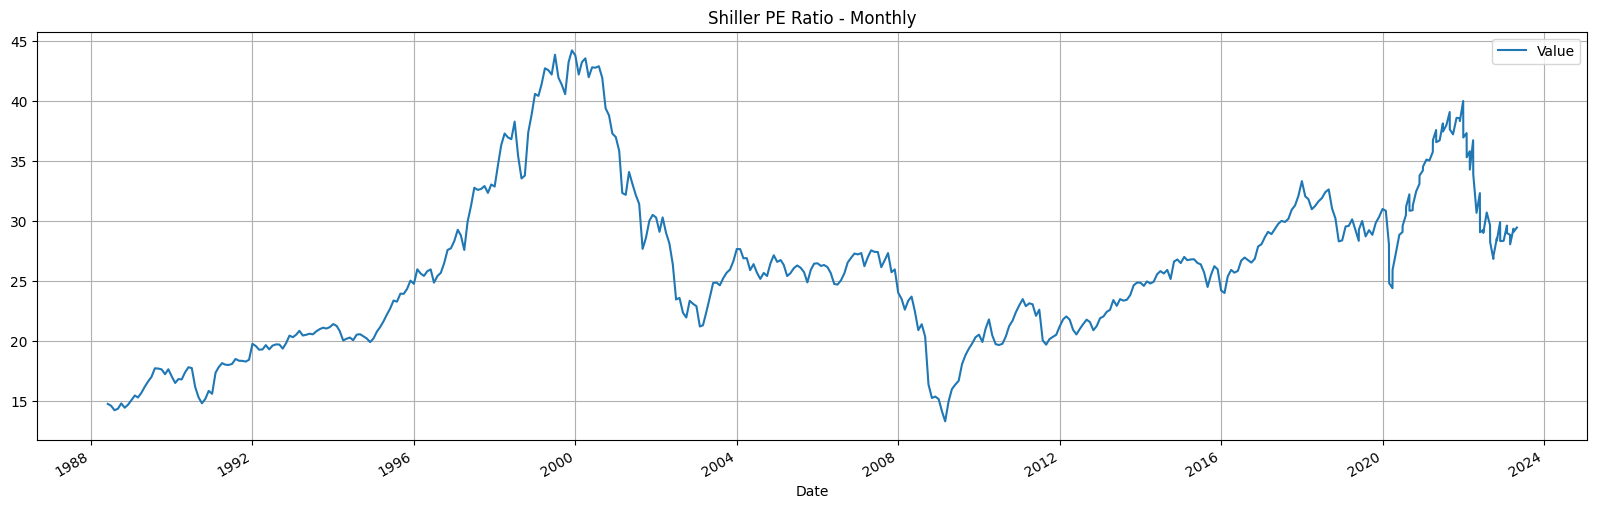

In [18]:
# https://www.multpl.com/shiller-pe
# https://data.nasdaq.com/data/MULTPL/SHILLER_PE_RATIO_MONTH-shiller-pe-ratio-by-month
macro_indicators['MULTPL_SHILLER_PE_RATIO_MONTH'].plot.line(figsize=(20,6), grid = True, title='Shiller PE Ratio - Monthly')

<Axes: title={'center': 'All Employees, Manufacturing (MANEMP) - Monthly'}, xlabel='DATE'>

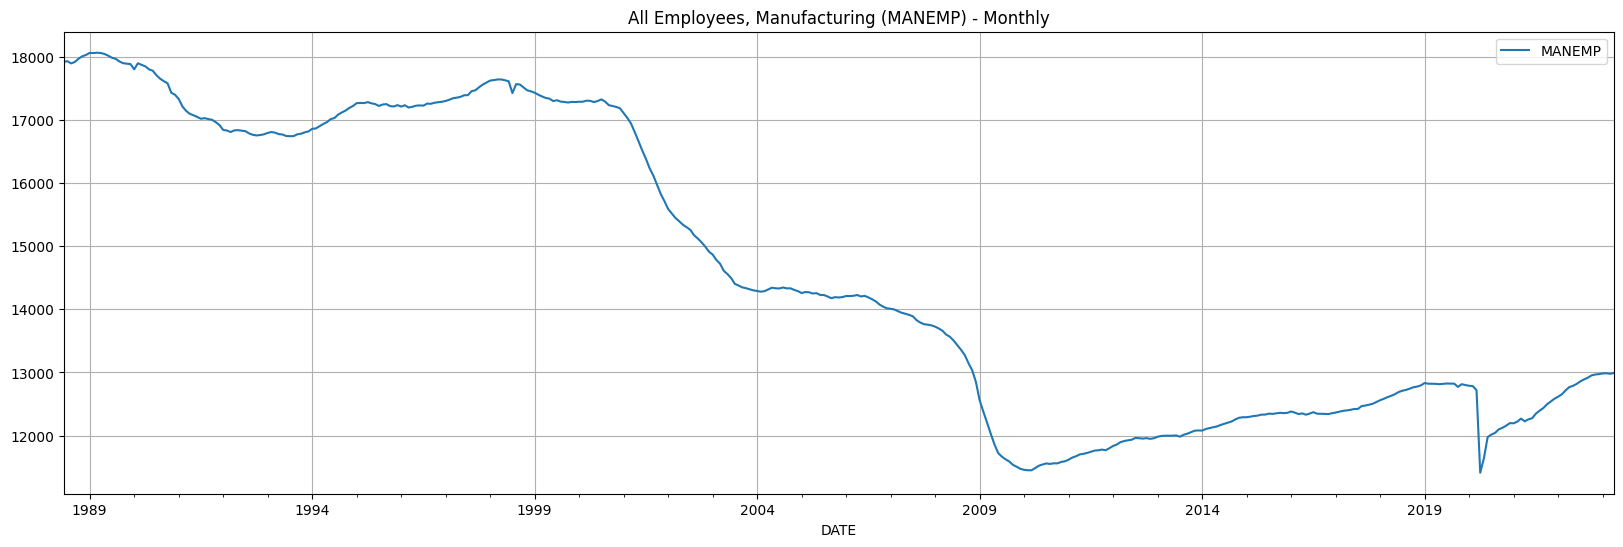

In [19]:
# https://fred.stlouisfed.org/series/MANEMP
macro_indicators['MANEMP'].plot.line(figsize=(20,6), grid = True, title='All Employees, Manufacturing (MANEMP) - Monthly')

In [20]:
print("Macro economic indicators used")
macro_indicators.keys()

Macro economic indicators used


dict_keys(['GDP', 'GDPC1', 'GDPPOT', 'NYGDPMKTPCDWLD', 'CPIAUCSL', 'CPILFESL', 'GDPDEF', 'M1SL', 'WM1NS', 'WM2NS', 'M1V', 'M2V', 'WALCL', 'DFF', 'DTB3', 'DGS2', 'DGS5', 'DGS10', 'DGS30', 'T5YIE', 'T10YIE', 'T5YIFR', 'TEDRATE', 'DPRIME', 'UNRATE', 'NROU', 'CIVPART', 'EMRATIO', 'UNEMPLOY', 'PAYEMS', 'MANEMP', 'ICSA', 'IC4WSA', 'CDSP', 'MDSP', 'FODSP', 'DSPIC96', 'PCE', 'PCEDG', 'PSAVERT', 'DSPI', 'RSXFS', 'INDPRO', 'TCU', 'HOUST', 'GPDI', 'CP', 'STLFSI2', 'DCOILWTICO', 'DTWEXAFEGS', 'DTWEXBGS', 'GFDEBTN', 'GFDEGDQ188S', 'DEXUSEU', 'GVZCLS', 'VIXCLS', 'DIVIDEND', 'MORTGAGE30US', 'SPCS20RSA', 'USTREASURY_YIELD', 'USTREASURY_REALYIELD', 'LBMA_GOLD', 'MULTPL_SHILLER_PE_RATIO_MONTH', 'BCHAIN_MKPRU', 'DJI', 'SPX'])